In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm 
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from model.AnomalyTransformer import AnomalyTransformer # https://github.com/thuml/Anomaly-Transformer 모델 사용, forward 부분 수정

# 1. 데이터 로드
normal_data = pd.read_csv('data/5528_12count/drop/5528_drop_imbalance_normal.csv')
error_data = pd.read_csv('data/5528_12count/drop/5528_drop_imbalance_error.csv')

# 2. null값 처리
normal_data = normal_data.dropna()
error_data = error_data.dropna()

# # rms_xyz 값이 0.03 이상인 데이터만 사용
# data = data[data['rms_xyz'] >= 0.03]


# 데이터의 시간 정보를 사용하여 훈련 데이터와 테스트 데이터 나누기
# created_at 유닉스 시간대 컬럼을 기준으로 시계열 정렬
normal_data['created_at'] = pd.to_datetime(normal_data['created_at'], unit='s')
error_data['created_at'] = pd.to_datetime(error_data['created_at'], unit='s')

normal_data = normal_data.sort_values(by='created_at')
error_data = error_data.sort_values(by='created_at')

# 훈련 데이터와 테스트 데이터 분할 -> 에러데이터+정상데이터 합치기

In [2]:
normal_data.shape, error_data.shape

((2220, 46), (192, 46))

In [3]:
train_data = normal_data
test_data = error_data

In [4]:
train_data.shape, test_data.shape

((2220, 46), (192, 46))

In [5]:
# 3. 필요한 특성 선택
train_features = train_data.drop(columns=['asset_id', 'created_at', 'created_at_datetime', 'looseness_health', 'time','misalignment_health', 'bearing_health', 'imbalance_health'])
test_features = test_data.drop(columns=['asset_id', 'created_at', 'created_at_datetime', 'looseness_health', 'time','misalignment_health', 'bearing_health', 'imbalance_health'])

# train_features = train_features.loc[:,['vel_crest_factor_x', 'rms_x', 'vel_kurtosis_y','vel_kurtosis_z', 'vel_peak_z','skewness_y','crest_factor_y','vel_skewness_x','vel_rms_xyz','peak_y','peak_x']]
# test_features = test_features.loc[:,['vel_crest_factor_x', 'rms_x', 'vel_kurtosis_y','vel_kurtosis_z', 'vel_peak_z','skewness_y','crest_factor_y','vel_skewness_x','vel_rms_xyz','peak_y','peak_x']]

In [6]:
train_features.columns.to_list()

['rms_x',
 'rms_y',
 'rms_z',
 'rms_xyz',
 'vel_rms_x',
 'vel_rms_y',
 'vel_rms_z',
 'vel_rms_xyz',
 'skewness_x',
 'skewness_y',
 'skewness_z',
 'vel_skewness_x',
 'vel_skewness_y',
 'vel_skewness_z',
 'kurtosis_x',
 'kurtosis_y',
 'kurtosis_z',
 'vel_kurtosis_x',
 'vel_kurtosis_y',
 'vel_kurtosis_z',
 'crest_factor_x',
 'crest_factor_y',
 'crest_factor_z',
 'vel_crest_factor_x',
 'vel_crest_factor_y',
 'vel_crest_factor_z',
 'peak_x',
 'peak_y',
 'peak_z',
 'vel_peak_x',
 'vel_peak_y',
 'vel_peak_z',
 'peak2peak_x',
 'peak2peak_y',
 'peak2peak_z',
 'vel_peak2peak_x',
 'vel_peak2peak_y',
 'vel_peak2peak_z']

In [7]:
train_features.shape , test_features.shape

((2220, 38), (192, 38))

In [8]:
# # 슬라이딩 윈도우 생성 시 12칸씩 슬라이딩 하려면 사용할 것
# train_features = train_features[:11]
# test_features = test_features[:24]

In [9]:
# 4. 정규화
scaler = MinMaxScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features) # 테스트 데이터는 fit하면 안됨

# 5. 슬라이딩 윈도우 생성
window_size = 12 # 2시간 단위를 하루 단위의 status 지표에 맞추기 위해 12 사용
def create_windows(data, window_size):
    # return [data[i:i+window_size] for i in range(len(data) - window_size + 1)] # 1칸씩 슬라이딩 (123, 234, 345 ...)
    return [data[i:i + window_size] for i in range(0, len(data), window_size)] # window_size 만큼 구분지어 슬라이딩 (123, 456, 789 ...)
def create_windows_for_test(data, window_size):
    # return [data[i:i+window_size] for i in range(len(data) - window_size + 1)] # 1칸씩 슬라이딩 (123, 234, 345 ...)
    return [data[i:i + window_size] for i in range(0, len(data), window_size)] # window_size 만큼 구분지어 슬라이딩 (123, 456, 789 ...)

train_windows = create_windows(train_features_scaled, window_size)
test_windows = create_windows_for_test(test_features_scaled, window_size)

# 6. PyTorch 텐서로 변환
train_windows_tensor = torch.tensor(np.array(train_windows), dtype=torch.float32)
test_windows_tensor = torch.tensor(np.array(test_windows), dtype=torch.float32)

In [10]:
# for i, window in enumerate(train_windows):
#     print(f"Window {i} length: {len(window)}")
# for i, window in enumerate(test_windows):
#     print(f"Window {i} length: {len(window)}")

In [11]:
# 7. 데이터셋 및 데이터로더 생성
train_dataset = TensorDataset(train_windows_tensor)
test_dataset = TensorDataset(test_windows_tensor)

train_dataloader = DataLoader(train_dataset, batch_size=36, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=36, shuffle=False)

In [12]:
# 8. 모델 정의
model = AnomalyTransformer(win_size=window_size,  # 슬라이딩 윈도우 크기
                           enc_in=train_features.shape[1],  # 입력 특성 수
                           c_out=train_features.shape[1],  # 출력 특성 수
                          d_model=38)  
# 가능한 경우 cuda 사용
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

# 9. 손실 함수 / 옵티마이저 설정
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
# 10. 모델 학습
num_epochs = 100

best_loss = float('inf')  # 초기값으로 무한대 설정
best_model_state = None    # 최적 모델의 상태 저장

for epoch in tqdm(range(num_epochs)):
    model.train()
    epoch_loss = 0
    for batch in train_dataloader:
        inputs = batch[0].to(device)
        
        # 순전파
        outputs, series, prior, sigmas = model(inputs)

        # 손실 함수 적용
        loss = criterion(outputs, inputs)
        
        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss}')

    # 최적 모델 업데이트
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_model_state = model.state_dict()  # 모델의 상태 저장

# 훈련 후 최적 모델 저장
if best_model_state is not None:
    torch.save(best_model_state, '0925_best_model_anomaly_transformer.pth')

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Loss: 0.8779660860697428
Epoch 2/100, Loss: 0.734236607948939
Epoch 3/100, Loss: 0.7076890369256338
Epoch 4/100, Loss: 0.6781732042630514
Epoch 5/100, Loss: 0.6513810257116953
Epoch 6/100, Loss: 0.6343644857406616
Epoch 7/100, Loss: 0.6152030328909556
Epoch 8/100, Loss: 0.6001104911168417
Epoch 9/100, Loss: 0.5857464770476023
Epoch 10/100, Loss: 0.5707417825857798
Epoch 11/100, Loss: 0.5567598541577657
Epoch 12/100, Loss: 0.5428271691004435
Epoch 13/100, Loss: 0.5290874044100443
Epoch 14/100, Loss: 0.515595555305481
Epoch 15/100, Loss: 0.5022250711917877
Epoch 16/100, Loss: 0.48911820848782855
Epoch 17/100, Loss: 0.47615712384382886
Epoch 18/100, Loss: 0.4633314609527588
Epoch 19/100, Loss: 0.4506952663262685
Epoch 20/100, Loss: 0.43822099765141803
Epoch 21/100, Loss: 0.42589643597602844
Epoch 22/100, Loss: 0.41371739904085797
Epoch 23/100, Loss: 0.4016677439212799
Epoch 24/100, Loss: 0.3897410084803899
Epoch 25/100, Loss: 0.3779187500476837
Epoch 26/100, Loss: 0.366175969

In [14]:
# 11. 모델 평가 (스코어링)
model.load_state_dict(torch.load('0925_best_model_anomaly_transformer.pth'))
model.eval()

criterion = nn.MSELoss(reduction='none')
anomaly_scores = []

with torch.no_grad():
    for batch in test_dataloader:
        inputs = batch[0].to(device)
        outputs, series, prior, sigmas = model(inputs)
        
        # 재구성 오차로 이상점수 계산
        batch_scores = criterion(outputs, inputs).mean(dim=(1,2)).cpu().numpy()
        anomaly_scores.extend(batch_scores)

C:\Users\user\AppData\Local\Temp\ipykernel_13560\706630034.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('0925_best_model_anomaly_tran

In [16]:
# 12. 임계값 계산
mean_score = np.mean(anomaly_scores)
std_score = np.std(anomaly_scores)

print(f'평균 스코어: {mean_score:.6f}')
print(f'표준편차: {std_score:.6f}')

# 임계값 설정 (평균 + 임의값 * 표준편차)

threshold = mean_score + 0.524 * std_score
print(f'임계값: {threshold:.6f}')

# 이상 점수 판별
anomalies = anomaly_scores > threshold
print(f'이상 점수 인덱스: {np.where(anomalies)[0]}')

평균 스코어: 0.014633
표준편차: 0.007097
임계값: 0.018352
이상 점수 인덱스: [ 0  4 13 14]


In [17]:
임계값=threshold

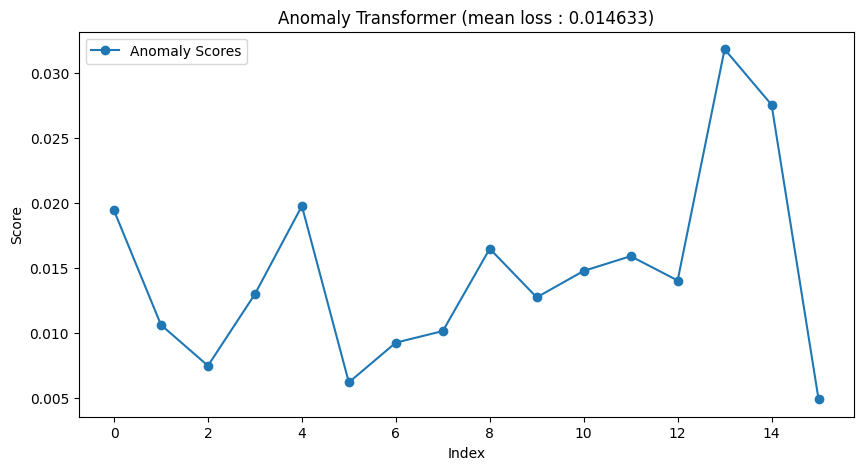

In [18]:
# 13. 인덱스 및 이상 점수 시각화
anomaly_indices = np.where(anomalies)[0]

plt.figure(figsize=(10, 5))
plt.plot(anomaly_scores, label='Anomaly Scores', marker='o')
# plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
# plt.ylim(0,0.05)
plt.xlabel('Index')
plt.ylabel('Score')
# plt.title(f'tested error data (Threshold : {format(threshold, '.6f')} (30%))')
plt.title(f'Anomaly Transformer (mean loss : {format(mean_score, '.6f')})')
plt.legend()
plt.show()

In [19]:
# 이상탐지된 인덱스 비교용
test_data_result=test_data.reset_index(drop=True)
# test_data_result=test_data.reset_index(drop=True)
indices = np.where(anomalies)[0].tolist()
test_data_result.iloc[[x * 12 for x in indices]]

# test_data_result.loc[indices].to_csv("anomaly_transformer_result.csv")


,asset_id,created_at,created_at_datetime,rms_x,rms_y,rms_z,rms_xyz,vel_rms_x,vel_rms_y,vel_rms_z,...,peak2peak_y,peak2peak_z,vel_peak2peak_x,vel_peak2peak_y,vel_peak2peak_z,time,imbalance_health,misalignment_health,looseness_health,bearing_health
0,55285839-9b78-48d8-9f4e-573190ace016,2024-01-08 15:46:38,2024-01-09 0:46,0.016531,0.016529,0.018887,0.030053,0.210037,0.265122,0.297471,...,0.111328,0.134766,1.23124,1.60734,1.74677,2024-01-10 0:00,0.924009,0.975000,0.975000,1
48,55285839-9b78-48d8-9f4e-573190ace016,2024-01-28 16:19:59,2024-01-29 1:19,0.016694,0.019169,0.019576,0.032084,0.265744,0.269427,0.286566,...,0.134766,0.152344,1.37813,1.59851,1.75334,2024-01-30 0:00,0.857143,0.985714,0.985714,1
156,55285839-9b78-48d8-9f4e-573190ace016,2024-07-04 15:47:59,2024-07-05 0:47,0.017481,0.020843,0.019941,0.033730,0.258710,0.265254,0.354965,...,0.146484,0.158203,1.62931,1.61003,2.21316,2024-07-06 0:00,0.899079,0.980000,0.980000,1
168,55285839-9b78-48d8-9f4e-573190ace016,2024-07-11 15:56:52,2024-07-12 0:56,0.026773,0.030524,0.020584,0.045522,0.245720,0.254808,0.401116,...,0.181641,0.146484,1.61777,1.50482,2.11734,2024-07-13 0:00,0.967173,0.989058,0.989058,1


In [20]:
multiples_of_12_indices = [i for i in range(len(test_data)) if i % 12 == 0]
result = test_data.iloc[multiples_of_12_indices].imbalance_health

In [21]:
result

0      0.924009
12     0.878773
24     0.939328
36     0.888119
48     0.857143
60     0.925000
72     0.666667
84     0.806524
96     0.639635
108    0.850000
120    0.836673
132    0.925000
144    0.950000
156    0.899079
168    0.967173
180    0.981797
Name: imbalance_health, dtype: float64